### Import Dependencies & Load Files

In [14]:
#Import dependencies 
import pandas as pd 
import numpy as np
from _loadData import LoadData
loader = LoadData()
import json 
import networkx as nx
from networkx.algorithms import community as nxcom
from networkx.readwrite import json_graph
import matplotlib.pyplot as plt
import itertools
from collections import Counter

In [2]:
# Read files into notebook using the "loader" (see loadData.py).  
attributes, edgeList, stats, vertex2aid = loader.load_files(sub_folder = "SNAP/")

### Inspect the Dimensions of the Datasets

In [3]:
# Check dimensions and type of the four files
loader.inspectDf("SNAP/")

 'Attributes.txt'  : ['Dimensions: (9073, 2)', "Type: <class 'pandas.core.frame.DataFrame'>"]
 'edgelist.txt'  : ['Dimensions: (37154, 2)', "Type: <class 'pandas.core.frame.DataFrame'>"]
 'Statistics.txt'  : ['Dimensions: (3, 1)', "Type: <class 'pandas.core.frame.DataFrame'>"]
 'vertex2aid.txt'  : ['Dimensions: (32812, 2)', "Type: <class 'pandas.core.frame.DataFrame'>"]


### Inspect the Content of the Attributes Dataset

'Attributes.txt' contains two columns: the first consists of row numbers, and the second consists of the Hashtags and Twitter Handles mentioned in the various Tweets that were scraped to form the dataset.  

Hashtags have the "#" symbol as a prefix, while mentions of Twitter Handles are identfied by the "@" symbol as the prefix.  

In [4]:
# Print the first ten rows of 'Attributes.txt' 
attributes.head()

,0,1
0,0,"#,"
1,1,#...
2,2,#1
3,3,#2
4,4,#3


In [5]:
#Print the last ten rows of 'Attributes.txt'
attributes.tail()

,0,1
9068,9068,@wideawakewesley
9069,9069,@wirebutterfly
9070,9070,@xiiislaughters
9071,9071,@zetabass
9072,9072,@zjhauri


### Inspect the Content of the Edge List Dataset

'edgelist.txt' contains the data describing all the edges in the network graph.  The first column should be the "source" nodes, and the second column should be the "tail" nodes.  

In [6]:
#Print the first ten rows of "edgelist.txt"
edgeList.head()

,0,1
0,338,458
1,338,464
2,338,463
3,338,460
4,338,461


### Inspect the Content of the Statistics Dataset

Three values are listed in the dataset:  

-  2511 is unknown, and probably relates to the 'Class_info.txt' dataset, which as of 03/08 I have been unable to load in.  
-  37154 is the number of rows in the 'edgelists.txt' dataset, and is therefore the number of edges contained in the network.  
-  9073 is the number of rows in the 'Attribute.txt' dataset, and is the number of attributes documented in the network.  


In [7]:
#Print the statistics dataset
stats

,0
0,2511
1,37154
2,9073


### Inspect the Vertex-To-Attribute-ID Dataset 

The 'vertex2aid.txt' document has data that maps the vertices (users on Twitter) that are mentioned in the Edge List dataset to each user's associated Attributes.  

In [8]:
#Print the first ten rows ot the 'vertex2aid' dataset 
vertex2aid.head()

,0,1
0,0,130
1,0,74
2,0,245
3,0,554
4,1,538


So for example, User (i.e., 'Vertex') '0' is associated with Attributes '130', '74', '245', and '554'.  

In [9]:
#Let's findout what Attributes these Attribute ID's are connected to
print(attributes.iloc[[74,130,245,554]])

       0         1
74    74     #SOPA
130  130     #from
245  245  @FoxNews
554  554  @twitter


So User 0 wrote at least one Tweet that had hashtags '#SOPA' & '#from' & mentioned two Twitter users, '@FoxNews' & '@twitter'.  

If we want to match Vertices to Attributes, we'll need to write a function that takes the vertices mentioned in the Edge List dataset, the Attribute IDs listed in the Attributes dataset, and use the information in the vertex2aid dataset to map Attributes to Vertices.  

### Manipulate and Merge Dataframes to Map UserID to Attribute ID to Attributes

In [10]:
tmp = vertex2aid.merge(attributes, how='left', left_on=1, right_on=0)
tmp = tmp.rename(columns={"1":"AID", "0_x":"UserID", "1_x":"AID", "0_y":"AID_y", "1_y":"Attributes"})
tmp = tmp.drop(columns=["AID_y"], axis=1)
Vertices2Attributes = tmp[["UserID","AID","Attributes"]]
Vertices2Attributes.head()

,UserID,AID,Attributes
0,0,130,#from
1,0,74,#SOPA
2,0,245,@FoxNews
3,0,554,@twitter
4,1,538,@sunterryjones


We can now easily identify the Attributes associated with each UserID.  This will make it easier when we try to actually understand how communities are formed, since everything can now be labeled in a human-readable format, as opposed to having communities being simply labelled by just a non-human interpretable Attribute ID number.

We can also simplify this further by dropping the Attribute ID entirely, but for now I'll leave it as, since it serves as a useful reference tool.

Our next step is to try and get this data transformed into a format that can represent a graph, such as an Edge List, Adjacency Matrix, or Adjacency List.  

The dataframe we just created, 'Vertices2Attributes', is essentially an Attributed Vertex List, but we should be able to easily use this to help us created an Attributed Edge List, and from there we may choose to create an Attributed Adjacency Matrix and/or an Attributed Adjacency List, depending on our needs.  

### Create an Attributed Edge List

In [11]:
tmp = edgeList.rename(columns={0:"Source", 1:"Tail"})
tmp = tmp.merge(Vertices2Attributes, how='left', left_on="Source", right_on="UserID")
tmp = tmp[["Source", "AID", "Attributes", "Tail"]]
tmp = tmp.rename(columns={"AID":"Src_AID", "Attributes":"Src_Attributes"})
tmp = tmp.merge(Vertices2Attributes, how="left", left_on="Tail", right_on="UserID")
tmp = tmp[["Source", "Src_AID", "Src_Attributes", "Tail", "AID", "Attributes"]]
tmp = tmp.rename(columns={"AID":"Tail_AID", "Attributes":"Tail_Attributes"})
tmp.head()

,Source,Src_AID,Src_Attributes,Tail,Tail_AID,Tail_Attributes
0,338,1802.0,@haurdCider:,458,1685.0,@TotallyAllen
1,338,1802.0,@haurdCider:,458,26.0,#FF
2,338,1802.0,@haurdCider:,458,1898.0,@petebeat:
3,338,1802.0,@haurdCider:,458,1992.0,@ziuqrd:
4,338,1802.0,@haurdCider:,458,1531.0,@Heckadecimal:


We now have an Attributed Edge List.  

But this current representation of an Edge List presents some problems.  First, we now have to duplicate row entries for the Source node multiple times in order to capture the Source-Attribute relation to every possible Tail-Attribute node connected to it.  

If we created a graph off of this, we'd be at risk of overwriting the same connection every time.

A better representation would be to move from this data frame to a list of lists, where each list is composed of three elements: 1) The Source ID; 2) The Tail ID; & 3) a list element where the first element (index 0) is a list containing the Sources' Attributes, and where the second element (index 1) is another list containing the Tails' Attributes.   



### Girvan-Newman For Community Detection with HTT Dataset

#### Define helper functions for visualization

In [16]:
# Helper Functions 
def set_node_community(G, communities): 
    for c, v_c in enumerate(communities): 
        for v in v_c: 
            G.nodes[v]["community"] = c + 1 
            
def set_edge_community(G): 
    for v, w in G.edges:
        if G.nodes[v]["community"] == G.nodes[w]["community"]:
            G.edges[v,w]["community"] = G.nodes[v]["community"]
        else: 
            G.edges[v,w]["community"] = 0 
            
def get_color(i, r_off=1,g_off=1, b_off=1):
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i+ r_off) * 3) % n) / (n - 1)
    g = low + span * (((i+ g_off) * 5) % n) / (n - 1)
    b = low + span * (((i+ b_off) * 7) % n) / (n - 1)
    return (r, g, b)

#### Load the JSON file and create a graph object

In [13]:
# Load JSON File of HTT Dataset
with open("data/HTT.json") as f: 
    data = json.load(f)
G_htt = json_graph.node_link_graph(data)

#### Fit a Girvan-Newman Model to the JSON Graph Object

In [14]:
# Fits girvan-newman to the HTT Network
result = nxcom.girvan_newman(G_htt)
communities = next(result)

In [15]:
# Display number of communities
print("Number of communities: ", len(communities))

Number of communities:  2


#### Visualize Results 

In [16]:
# Set node and edge communities 
set_node_community(G_htt, communities)
set_edge_community(G_htt)

# Set community color for nodes 
node_color = [
    get_color(G_htt.nodes[v]['community'])
    for v in G_htt.nodes
]

# Set community color for internal edges 
external = [(v,w) for v, w in G_htt.edges 
           if G_htt.edges[v,w]['community'] == 0]
internal = [(v,w) for v,w in G_htt.edges 
           if G_htt.edges[v,w]['community'] > 0]
internal_color = [
    get_color(G_htt.edges[e]['community'])
    for e in internal]

#htt_pos = nx.spring_layout(G_htt, k=0.3)
htt_pos = nx.kamada_kawai_layout(G_htt)

/home/stanley-yu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/stanley-yu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/home/stanley-yu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


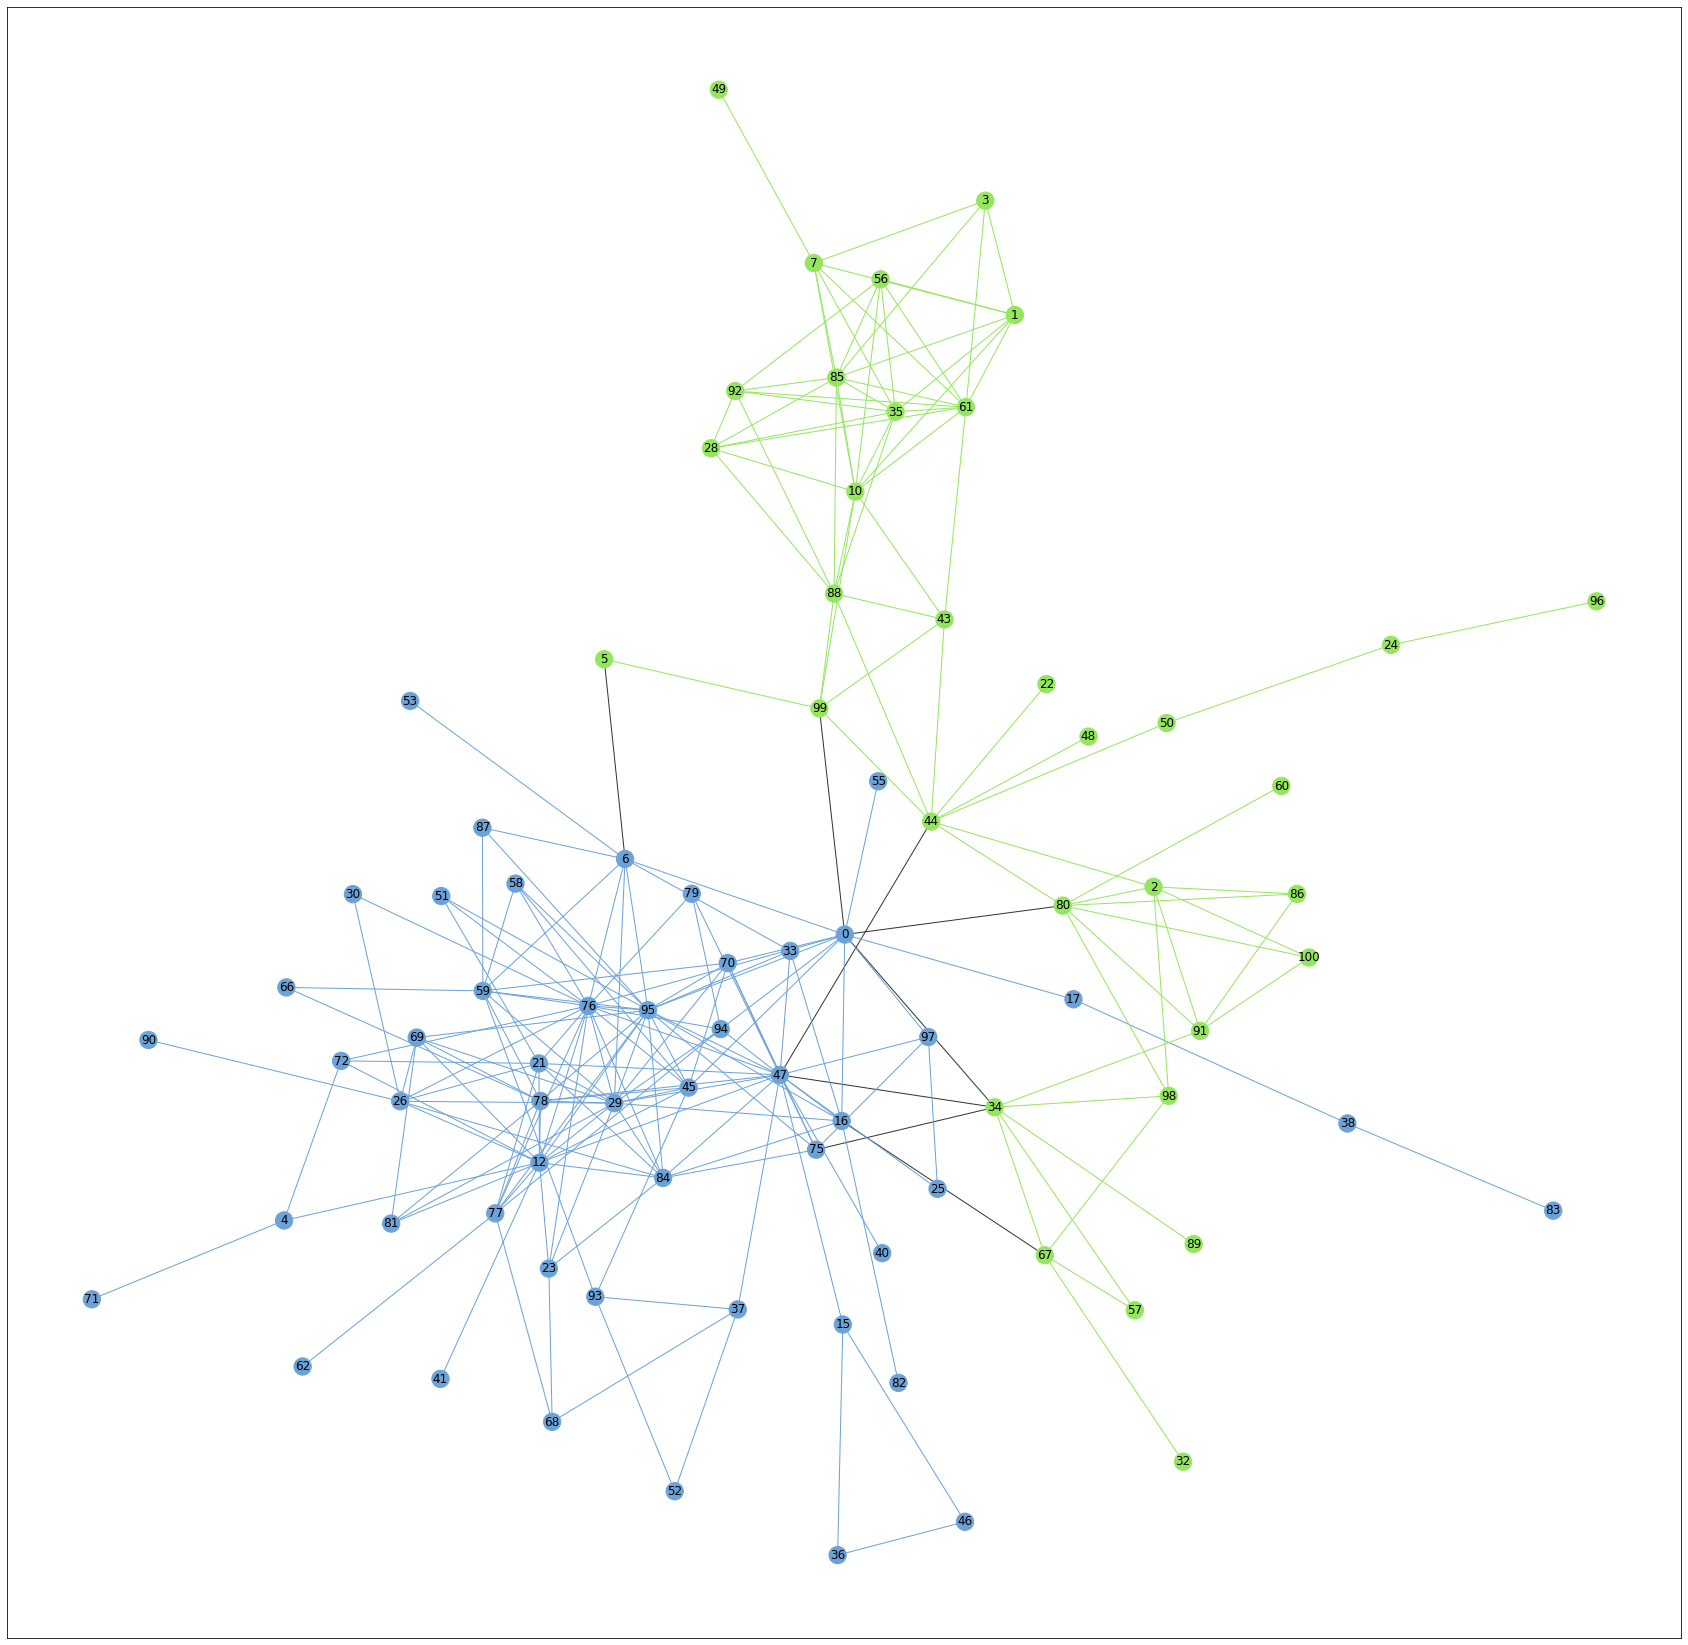

In [17]:
# Visualize 

fig, ax = plt.subplots(1,1,figsize=(30,30))

# Draw external edges
nx.draw_networkx(G_htt, pos=htt_pos, node_size=0, edgelist=external, edge_color="#333333", with_labels=False, ax=ax)
# Draw nodes and internal edges 
nx.draw_networkx(G_htt, pos=htt_pos, node_color=node_color, edgelist=internal, edge_color=internal_color, ax=ax)

The visualization seems to confirm the existence of at least two communities in the HTT Dataset when considered without attributes.  Let's now return the membership of the communities. 

#### Isolate the communities

In [18]:
# Get the first k tuples of communities 
k = 3
community_list = list()
limited = itertools.takewhile(lambda c: len(c) <= k, result)
for communities in limited:
    community_list.append(tuple(sorted(c) for c in communities))
    print(tuple(sorted(c) for c in communities))

([0, 4, 6, 12, 15, 16, 17, 21, 23, 25, 26, 29, 30, 33, 36, 37, 38, 40, 41, 45, 46, 47, 51, 52, 53, 55, 58, 59, 62, 66, 68, 69, 70, 71, 72, 75, 76, 77, 78, 79, 81, 82, 83, 84, 87, 90, 93, 94, 95, 97], [2, 22, 24, 32, 34, 44, 48, 50, 57, 60, 67, 80, 86, 89, 91, 96, 98, 100], [1, 3, 5, 7, 10, 28, 35, 43, 49, 56, 61, 85, 88, 92, 99])


#### Blue Community:

In [19]:
blue_cluster = community_list[0][0]

In [20]:
print(blue_cluster)

[0, 4, 6, 12, 15, 16, 17, 21, 23, 25, 26, 29, 30, 33, 36, 37, 38, 40, 41, 45, 46, 47, 51, 52, 53, 55, 58, 59, 62, 66, 68, 69, 70, 71, 72, 75, 76, 77, 78, 79, 81, 82, 83, 84, 87, 90, 93, 94, 95, 97]


#### Green Community:

In [21]:
green_cluster = sorted(community_list[0][1] + community_list[0][2])

In [22]:
print(green_cluster)

[1, 2, 3, 5, 7, 10, 22, 24, 28, 32, 34, 35, 43, 44, 48, 49, 50, 56, 57, 60, 61, 67, 80, 85, 86, 88, 89, 91, 92, 96, 98, 99, 100]


#### Map Community-Assigned Nodes to Attributes

In [23]:
bc_df = pd.DataFrame(blue_cluster, columns=["Node ID"])

In [24]:
gc_df = pd.DataFrame(green_cluster, columns=["Node ID"])

In [25]:
blu_mapped = bc_df.merge(Vertices2Attributes, how="left", left_on="Node ID", right_on="UserID")

In [26]:
grn_mapped = gc_df.merge(Vertices2Attributes, how="left", left_on="Node ID", right_on="UserID")

#### Isolate Unique Attributes per cluster

In [27]:
blu_unique = pd.unique(blu_mapped["Attributes"])
grn_unique = pd.unique(grn_mapped["Attributes"])

#### Counts of Attributes, Blue Community (greater than 3)

In [28]:
blu_counts = pd.DataFrame(blu_mapped["Attributes"]).sort_values(by="Attributes")
blu_counts = blu_counts.dropna()
#tmp.tail()
blu_counts = np.asarray(blu_counts)
blu_counts = list(blu_counts.flatten())
labels = Counter(blu_counts).keys()
values = Counter(blu_counts).values()
list_labels = list(labels)
list_values = list(values)
blu_counts = pd.DataFrame(np.column_stack([list_labels, list_values]), columns=["Attributes", "Counts"])
blu_counts[blu_counts["Counts"] > "3"]
out = blu_counts[blu_counts["Counts"] > "3"]
out.to_csv("blue_counts.csv")
out

,Attributes,Counts
15,#D3,4
150,@Dingo,5
175,@KimAms,4
178,@LitBomb,4
204,@Stepto,4
284,@lauralollipop,5
293,@majornelson:,4
313,@paullu,4
334,@thevowel,5
337,@trixie360,4


In [29]:
# new = tmp_df[tmp_df["Counts"] > "2"]
# new.astype({"Unique Attributes":"str","Counts":"int32"}).dtypes

#### Counts of Attributes, Green Community (greater than 3)

In [30]:
grn_counts = pd.DataFrame(grn_mapped["Attributes"]).sort_values(by="Attributes")
grn_counts = grn_counts.dropna()
#tmp.tail()
grn_counts = np.asarray(grn_counts)
grn_counts = list(grn_counts.flatten())
labels = Counter(grn_counts).keys()
values = Counter(grn_counts).values()
list_labels = list(labels)
list_values = list(values)
grn_counts = pd.DataFrame(np.column_stack([list_labels, list_values]), columns=["Attributes", "Counts"])
grn_counts[grn_counts["Counts"] > "3"]
out = grn_counts[grn_counts["Counts"] > "3"]
out.to_csv("green_counts.csv")
out

,Attributes,Counts
15,#Oilers,7
73,@NHL_Oilers:,5
100,@chris_miller,4
109,@ebs_14,6
110,@ebs_14:,4
118,@hallsy04,6
124,@jonesry28,5


### Girvan Newman with the COVID19 "Island" Edge List

In [31]:
# Read in Data
# Check dimensions and type of the four files
prefix = "~/Documents/github/Twitter-Network-Analysis/src/data/Island/"
island_edges = pd.read_csv(prefix + "connected_edges.csv")
island_nodes = pd.read_csv(prefix + "connected_nodes.csv")

print("First ten rows of the Island Edge List: ")
print(island_edges.head())
print("Dimensions:", np.shape(island_edges))
print("-----------------------------------------")
print("First ren rows of the Island Node List: ")
print(island_nodes.head())
print("Dimensions:", np.shape(island_nodes))

First ten rows of the Island Edge List: 
   Source  Target
0       1    2228
1       7    2092
2      10     196
3      10    1048
4      10    1338
Dimensions: (4788, 2)
-----------------------------------------
First ren rows of the Island Node List: 
         hashtag_name  hashtag_id
0  1000daysartwithnik           1
1             16marzo           6
2                  1A           7
3            2019nCoV          10
4           20seconds          12
Dimensions: (1826, 2)


In [27]:
import pandas as pd
import networkx as nx
df = pd.read_csv("data/Island/connected_edges.csv").query('Source <= 1000 & Target <=1000')

df

,Source,Target
2,10,196
9,13,614
20,27,87
24,38,227
25,38,713
...,...,...
1157,999,431
1158,999,470
1159,999,906
1164,1000,233


In [28]:
g_temp = nx.from_pandas_edgelist(df, 'Source', 'Target')

In [21]:
G_island=nx.Graph()
G_island.add_edges_from(np.asarray(island_edges))

NameError: name 'island_edges' is not defined

In [29]:
import time
start = time.time()
result = nxcom.girvan_newman(G_island)
communities = next(result)
print("Number of communities: ", len(communities)) 
# Set node and edge communities
set_node_community(G_island, communities)
set_edge_community(G_island)
# Set community color for nodes 
node_color = [get_color(G_island.nodes[v]['community']) for v in G_island.nodes]
# Set community color for internal edges 
external = [ (v,w) for v, w in G_island.edges if G_island.edges[v,w]['community'] == 0] 
internal =  [(v,w) for v, w in G_island.edges if G_island.edges[v,w]['community'] > 0]
internal_color = [get_color(G_island.edges[e]['community']) for e in internal]
print(f"Done {time.time()-start} seconds")

Number of communities:  64
Done 0.25115084648132324 seconds


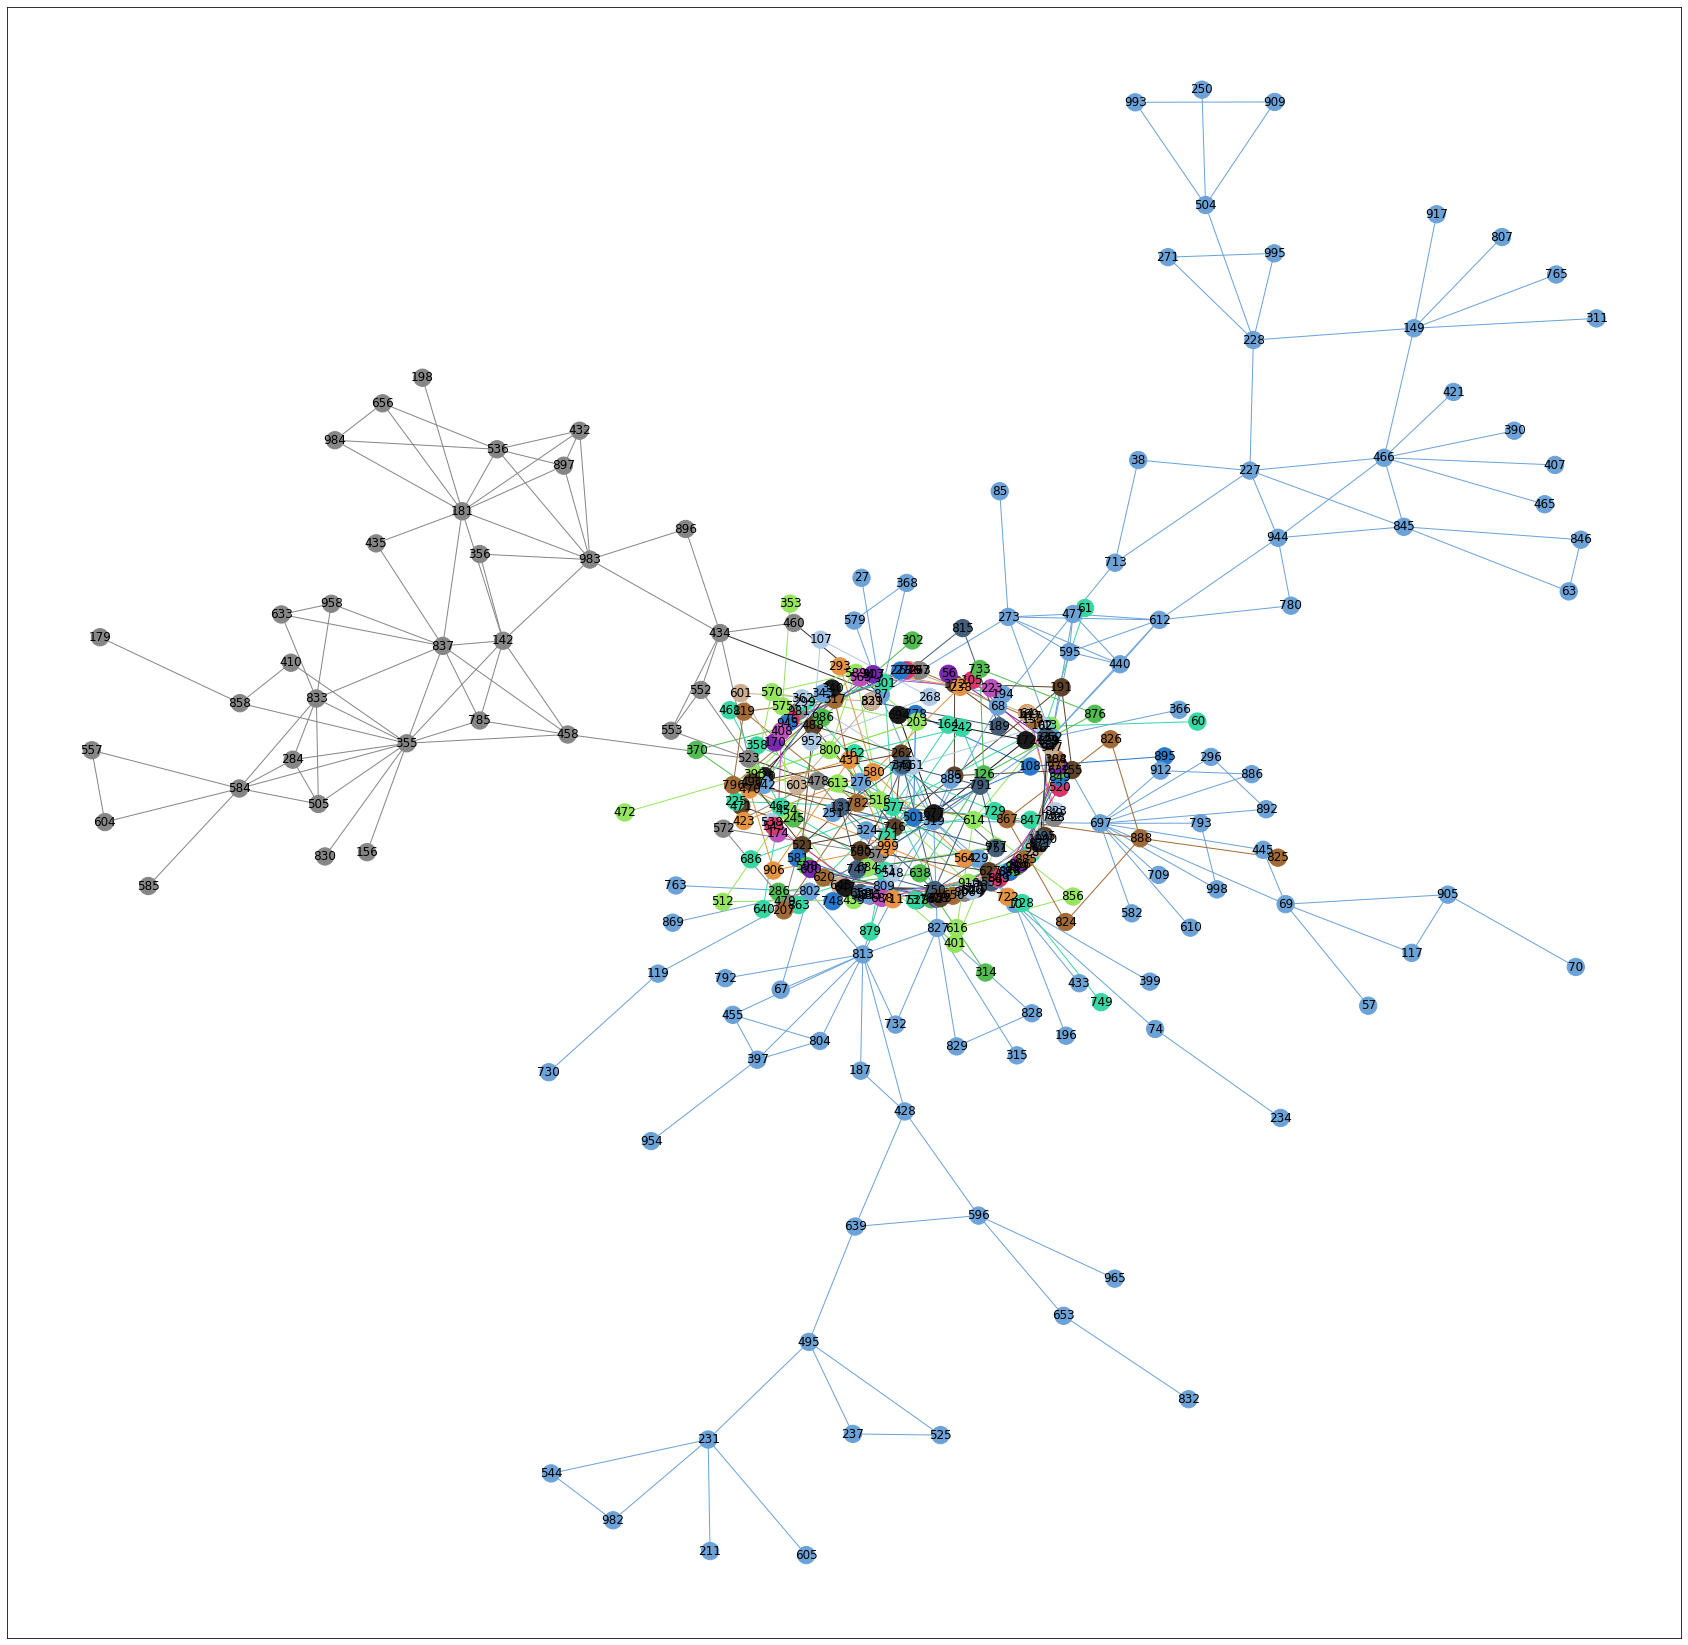

In [30]:
# Calculate layout 
#pos = nx.spring_layout(G_island, k =0.1)
pos = nx.kamada_kawai_layout(G_island)
# Visualize 
fig, ax = plt.subplots(1,1,figsize=(30,30))
# Draw external edges 
nx.draw_networkx(G_island, pos=pos, node_size = 0, edgelist=external, edge_color = "#333333", with_labels = False) 
# Draw nodes and internal edges 
nx.draw_networkx(G_island, pos=pos, node_color=node_color, edgelist=internal, edge_color=internal_color)

The code written below, according to the documentation provided by NetworkX, is supposed to print the first two communities of the network, however whenever I run this code, nothing happens.  The next chunk is also intended to have the same effect, but instead seems to split the second community into two, which is unexpected.  

In [38]:
k = 2
limited = itertools.takewhile(lambda c: len(c) <= k, result)
for communities in limited:
    print(tuple(sorted(c) for c in communities)) 

The code written below, according to the documentation provided by NetworkX, is supposed to print the first two communities of the network, however, it would instead appear to be printing the first three, with the second community being bifurcated into two communities, which stand in contrast to the examples listed in the documentation.  

In [ ]:
# Print the first two comuunities 

print(tuple(sorted(c) for c in next(result)))

The following is also intended to print the first two communities, but again produces unexpected results.  

In [36]:
# Print the first two comuunities 

print(tuple(sorted(c) for c in next(result)))

67


The following is also intended to print the first two communities, but again produces unexpected results.  

In [37]:
# next(result)

In [38]:
# Get the first k tuples of communities 
# k = 3
# community_list = list()
# limited = itertools.takewhile(lambda c: len(c) <= k, result)
# for communities in limited:
#     community_list.append(tuple(sorted(c) for c in communities))
#     print(tuple(sorted(c) for c in communities))

The code below is a little out of date, but it's intended to take the communities generated and map them to their corresponding entries in the node list. 

In [39]:
# from pandasql import sqldf
# pysqldf = lambda q: sqldf(q, globals())

In [40]:
# q = """
#     SELECT
#         *
#     FROM
#         island_nodes a
#     INNER JOIN
#         community_one b
#            ON a.hashtag_id = b.hashtag_id;"""
# joined = pysqldf(q)
# print(joined.head())
# print("Dimensions: ", np.shape(joined))

In [41]:
# joined.sample(n=50, random_state=0)

In [42]:
# community_2 = [4, 655, 675, 738]
# community_2 = pd.DataFrame(community_2, columns = ["hashtag_id"])
# print("Dimensions of Community 2: ", np.shape(community_2))

In [43]:
# q = """
#     SELECT
#         *
#     FROM
#         island_nodes a
#     INNER JOIN
#         community_2 b
#            ON a.hashtag_id = b.hashtag_id;"""
# joined2 = pysqldf(q)
# print(joined2)

In [44]:
# community_3 = [12, 13, 22, 29, 32, 38, 87, 98, 106, 116, 126, 139, 170, 304, 372, 377, 381, 389, 406, 430, 441, 484, 487, 504, 513, 537, 544, 549, 564, 579, 585, 596, 611, 622, 
#  679, 710, 712, 739, 899]
# community_3 = pd.DataFrame(community_3, columns = ["hashtag_id"])
# print("Dimensions of Community 3: ", np.shape(community_3))
# q = """
#     SELECT
#         *
#     FROM
#         island_nodes a
#     INNER JOIN
#         community_3 b
#            ON a.hashtag_id = b.hashtag_id;"""
# joined3 = pysqldf(q)
# print(joined3)

In [ ]:
import snap

In [ ]:
# SNAP Girvan-Newman Demo
# UGraph = snap.GenRndGnm(snap.PUNGraph, 100, 1000)
# CmtyV = snap.TCnComV()
# modularity = snap.CommunityGirvanNewman(UGraph, CmtyV)
# for Cmty in CmtyV:
#     print("Community: ")
#     for NI in Cmty:
#         print(NI)
# print("The modularity of the network is %f" % modularity)

In [ ]:
G6 = snap.TUNGraph.New(island_nodes, island_edges)

In [46]:
# SNAP Girvan-Newman Demo
# UGraph = snap.GenRndGnm(snap.PUNGraph, 100, 1000)
# CmtyV = snap.TCnComV()
# modularity = snap.CommunityGirvanNewman(UGraph, CmtyV)
# for Cmty in CmtyV:
#     print("Community: ")
#     for NI in Cmty:
#         print(NI)
# print("The modularity of the network is %f" % modularity)

In [47]:
# Function to build graphs via SNAP PY
def build_graph(node_list, edge_list): 
    from tqdm import tqdm
    import time 
    
    start_time = time.time()
    G = snap.TUNGraph().New() # Initialize empty 'SNAP' Graph
    # Add nodes to empty graph
    print("Adding nodes to graph... ")
    tmparr = np.asarray(node_list) 
    for i in tqdm(tmparr[:,1]): 
        G.AddNode(i)
    # Add edges to empty graph 
    print("Adding edges to graph... ")
    nrows, ncols = np.shape(edge_list)
    tmparr = np.asarray(edge_list)
    for i in tqdm(range(nrows)): 
        s = int(tmparr[i,0])
        t = int(tmparr[i,1])
        G.AddEdge(s,t)
    print("Graph construction complete.  Time elapsed: ", time.time() - start_time)
    return G

In [48]:
G6 = build_graph(island_nodes, island_edges)

100%|██████████| 4788/4788 [00:00<00:00, 149484.37it/s]

Adding nodes to graph... 
Adding edges to graph... 
Graph construction complete.  Time elapsed:  0.05998539924621582


In [49]:
import time

start = time.time()
CmtyV = snap.TCnComV()
modularity = snap.CommunityGirvanNewman(G6, CmtyV)
i = 1
for Cmty in CmtyV:
    print(f"Community {i}: ")
    print(list(Cmty))
    print("\n")
    i += 1
print("The modularity of the network is %f" % modularity)
print(f"Time : {time.time()-start} seconds")

Community 1: 
[17, 56, 112, 121, 129, 137, 150, 151, 173, 176, 198, 202, 263, 463, 559, 620, 644, 645, 646, 650, 658, 731, 774, 841, 873, 919, 923, 924, 981, 988, 990, 1050, 1204, 1207, 1214, 1256, 1259, 1290, 1299, 1311, 1355, 1437, 1449, 1452, 1478, 1485, 1499, 1509, 1512, 1534, 1537, 1543, 1544, 1555, 1562, 1565, 1572, 1594, 1630, 1645, 1647, 1652, 1688, 1689, 1696, 1720, 1792, 1798, 1812, 1848, 1950, 1975, 1976, 1989, 1997, 2064, 2083, 2090, 2123, 2129, 2135, 2164, 2239, 2292, 2309, 2425, 2474, 2507, 2539, 2548, 2551, 2598, 2602, 2657, 2791, 2838, 2882, 2885, 2905, 2906, 2907, 2913, 2990, 3028, 3038, 3087, 3121, 3144, 3186, 3195, 3279, 3302, 3315, 3367, 3380, 3434, 3461, 3474, 3477, 3483, 3487]


Community 2: 
[7, 21, 67, 159, 178, 212, 251, 276, 297, 315, 319, 324, 397, 455, 520, 632, 698, 732, 761, 763, 779, 792, 802, 804, 809, 813, 827, 828, 829, 843, 857, 859, 868, 869, 883, 931, 954, 1009, 1023, 1109, 1127, 1164, 1166, 1194, 1202, 1215, 1276, 1354, 1365, 1369, 1415, 1416, 1444

### Clauset-Newman-Moore 

In [50]:
G7 = build_graph(island_nodes, island_edges)

100%|██████████| 4788/4788 [00:00<00:00, 305522.93it/s]

Adding nodes to graph... 
Adding edges to graph... 
Graph construction complete.  Time elapsed:  0.023151874542236328


In [51]:
import os.path 

save_path = 'data/Island/'
filename = "cnmCommunities"
complete_name = os.path.join(save_path, filename+".txt")
community_list = [] 
with open(complete_name, 'w') as file_object: 
    start = time.time()
    CmtyV2 = snap.TCnComV()
    modularity2 = snap.CommunityCNM(G7, CmtyV2)
    i = 1
    for Cmty in CmtyV2:
        print(f"Community {i}: ")
        print(list(Cmty))
        print("\n")
        file_object.write(f"Community {i}: \n")
        file_object.write(str(list(Cmty)))
        file_object.write("\n")
        community_list.append(list(Cmty))
        i += 1
    print("The modularity of the network is %f" % modularity)
    print(f"Time : {time.time()-start} seconds")

Community 1: 
[1, 12, 49, 64, 104, 105, 157, 164, 187, 297, 299, 301, 352, 353, 397, 428, 439, 454, 455, 478, 479, 512, 514, 572, 573, 575, 596, 686, 693, 703, 767, 790, 792, 798, 804, 806, 809, 813, 834, 855, 920, 922, 936, 954, 962, 965, 1009, 1027, 1038, 1039, 1096, 1115, 1120, 1139, 1153, 1189, 1190, 1221, 1223, 1239, 1240, 1264, 1272, 1300, 1325, 1332, 1334, 1339, 1343, 1346, 1387, 1448, 1453, 1459, 1474, 1481, 1482, 1483, 1486, 1491, 1526, 1535, 1561, 1602, 1620, 1633, 1642, 1653, 1666, 1686, 1694, 1779, 1783, 1794, 1840, 1876, 1883, 1886, 1911, 1917, 1924, 1932, 1954, 1968, 1990, 1991, 2000, 2009, 2042, 2046, 2068, 2069, 2085, 2089, 2110, 2119, 2156, 2157, 2177, 2181, 2188, 2194, 2196, 2200, 2201, 2212, 2213, 2226, 2228, 2234, 2241, 2256, 2277, 2280, 2285, 2296, 2316, 2326, 2335, 2340, 2348, 2351, 2365, 2370, 2371, 2398, 2402, 2404, 2430, 2467, 2491, 2499, 2504, 2506, 2549, 2555, 2570, 2575, 2582, 2588, 2593, 2600, 2606, 2611, 2616, 2622, 2639, 2661, 2663, 2673, 2678, 2686, 2687

In [52]:
len(community_list)

43

In [53]:
len(community_list[0])*[1]
len(community_list[0])

245

# 

In [54]:
community_labels = [] 
j = 1
for i in range(len(community_list)): 
    community_len = len(community_list[i])
    community_labels.append(community_len*[j])
    #community_labels.append(len(community_list[i])*[j])
    j += 1

In [55]:
flat_community_labels = [] 
for sublist in community_labels: 
    for i in sublist: 
        flat_community_labels.append(i) 

In [56]:
community_list[1]

[6, 766, 1549, 1871, 1872, 1873, 2423, 2589, 2591, 3086, 3098, 3224]

In [57]:
flat_nodes = [] 
for sublist in community_list: 
    for i in sublist: 
        flat_nodes.append(i) 

In [58]:
cnm_communities = {"Nodes" : flat_nodes, "Communities" : flat_community_labels}

In [59]:
cnm_comm_df = pd.DataFrame(cnm_communities, columns=['Nodes','Communities'])

In [60]:
cnm_comm_df

,Nodes,Communities
0,1,1
1,12,1
2,49,1
3,64,1
4,104,1
...,...,...
1821,2539,42
1822,2313,43
1823,2810,43
1824,2824,43


In [61]:
community_list[42]

[2313, 2810, 2824, 2865]

In [62]:
cnm_comm_df.head()

,Nodes,Communities
0,1,1
1,12,1
2,49,1
3,64,1
4,104,1


In [63]:
# Return labeled communities in dictionary format for plotting purposes.  
cnm_label_dict = {} 
for i in range(len(flat_nodes)): 
    sup_key = flat_nodes[i] 
    lab_val = flat_community_labels[i]
    cnm_label_dict[sup_key] = {"CommunityLabel" : lab_val}

# sup_key = flat_nodes[i] 

In [64]:
from _generateGraph import HashtagGraph

In [65]:
generator = HashtagGraph() 
generator.load_csv("data/Hashtag_Raw_Data/COVID19_hashtags7.csv")
g = generator.Graph
print(len(list(g.nodes)))

3237


In [66]:
type(g.edges)

networkx.classes.reportviews.EdgeView

In [67]:
pd.DataFrame(g.edges, columns = ["Source", "Target"]).head()

,Source,Target
0,0,2379
1,1,2228
2,1,2828
3,1,3175
4,2228,2828


In [68]:
island_edges.head()

,Source,Target
0,1,2228
1,7,2092
2,10,196
3,10,1048
4,10,1338


In [69]:
np.shape(pd.DataFrame(g.edges, columns = ["Source", "Target"]))

(5706, 2)

In [70]:
np.shape(island_edges)

(4788, 2)

In [71]:
from _detectCommunities import CommunityDetector

NameError: name 'G' is not defined

In [ ]:
cd = CommunityDetector()

In [ ]:
graph_obj1a = cd.createGraphObj("data/Hashtag_Raw_Data/COVID19_hashtags7.csv")